Импортируем все необходимые библиотеки

In [1]:
import numpy as np
from skimage.feature import canny
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from imageio import imread, imsave
from skimage.filters import sobel_v, sobel_h, gaussian
import cv2 as cv
from skimage.morphology import binary_erosion
import os
import random
from skimage.transform import (hough_line, hough_line_peaks)
from skimage.draw import circle

In [2]:
box_folder = "./box"
img_folder = "./test"

In [3]:
def getRandomImg(img_folder):
    files = os.listdir(path=img_folder)
    images = [i for i in filter(lambda x: x.endswith('.jpg'), files)]
    
    idx = random.randint(0, len(images) - 1)
    img_path = os.path.join(img_folder, images[idx])
    return cv.imread(img_path, cv.IMREAD_COLOR)

Загрузим случайное изображение из датасета.

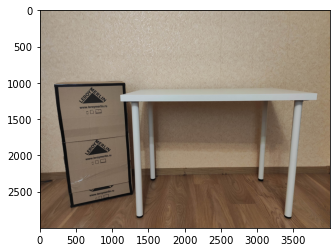

In [4]:
scene = getRandomImg(img_folder)
if (scene is None):
    print("Не удалось загрузить изображение")
else:
    scene_grayscale = cv.cvtColor(scene, cv.COLOR_BGR2GRAY)
    plt.imshow(cv.cvtColor(scene, cv.COLOR_BGR2RGB))

In [5]:
def m_findHomography(img_object, img_scene):
    detector = cv.ORB_create()
    keypoints_obj, descriptors_obj = detector.detectAndCompute(img_object, None)
    keypoints_scene, descriptors_scene = detector.detectAndCompute(img_scene, None)
    #-- Step 2: Matching descriptor vectors with a FLANN based matcher
    # Since SURF is a floating-point descriptor NORM_L2 is used
    matcher = cv.BFMatcher(cv.NORM_HAMMING)
    knn_matches = matcher.knnMatch(descriptors_obj, descriptors_scene, 2)
    #-- Filter matches using the Lowe's ratio test
    ratio_thresh = 0.9
    good_matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    H = None    
        
    if (len(good_matches) >= 4):
        #-- Draw matches
        img_matches = np.empty((max(img_object.shape[0], img_scene.shape[0]), img_object.shape[1]+img_scene.shape[1], 3), dtype=np.uint8)
        #-- Localize the object
        obj = np.empty((len(good_matches),2), dtype=np.float32)
        scene = np.empty((len(good_matches),2), dtype=np.float32)
        for i in range(len(good_matches)):
            #-- Get the keypoints from the good matches
            obj[i,0] = keypoints_obj[good_matches[i].queryIdx].pt[0]
            obj[i,1] = keypoints_obj[good_matches[i].queryIdx].pt[1]
            scene[i,0] = keypoints_scene[good_matches[i].trainIdx].pt[0]
            scene[i,1] = keypoints_scene[good_matches[i].trainIdx].pt[1]
        H, _ =  cv.findHomography(obj, scene, cv.RANSAC)
        
    return H

Попробуем найти объект на фото, при помощи поиска гомографии между исходным изображением и шаблоном объекта. Если гомография не была найдена, то считаем, что объект найти не удалось.

In [6]:
files = os.listdir(path=box_folder)
images = [i for i in filter(lambda x: x.endswith('.jpg'), files)]

for img_path in images:
    img_path = os.path.join(box_folder, img_path)
    box = cv.imread(img_path, 0)
    H = m_findHomography(box, scene_grayscale)
    
    if not H is None: continue
        
if H is None:
    print("Не удалось найти объект")

Здесь можно оценить найденное отображение и увидеть подходящий шаблон.

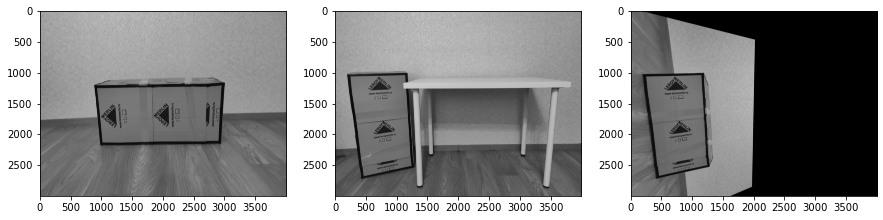

In [7]:
height = scene_grayscale.shape[0]
width = scene_grayscale.shape[1]
imReg = cv.warpPerspective(box, H, (width, height))

fig, ax = plt.subplots(1, 3, figsize=(15, 6))

ax[0].imshow(box, cmap='gray')
ax[1].imshow(scene_grayscale, cmap='gray')
ax[2].imshow(imReg, cmap='gray')

Найдём границы коробки на исходном изображении объекта. getLines - функция поиска линий на бинаризованном изображении при помощи преобразования Хафа.

In [8]:
def getLines(image, theta):
    h, theta, d = hough_line(image, theta=theta)

    it = zip(*hough_line_peaks(h, theta, d))
    _, angle, dist = next(it)
    
    min_angle = max_angle = angle
    min_dist = max_dist = dist
    
    for _, angle, dist in it:
        if (max_dist < dist):
            max_dist = dist
            max_angle = angle
        if (min_dist > dist):
            min_dist = dist
            min_angle = angle
            
    return [(max_dist, max_angle), (min_dist, min_angle)]

In [9]:
def getBorders(img, orient):
    if orient == 'vert':
        sobel_img = sobel_v(gaussian(img, sigma=5))
        theta = np.linspace(-np.pi/12, np.pi/12, num=20)
    if orient == 'horz':
        sobel_img = sobel_h(gaussian(img, sigma=5))
        theta = np.linspace(np.pi/2-0.3, np.pi/2 + 0.3, num=20)
    
    sobel_img = np.abs(sobel_img)
    thresh_img = sobel_img > np.mean(sobel_img)*5
    return getLines(thresh_img, theta)

Здесь находим уравнение линий границ коробки (угл и смещение)

In [10]:
vert_lines = getBorders(box, 'vert')
horz_lines = getBorders(box, 'horz')

In [11]:
def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]

Найдём точки пересечения линий. Это и будут углы нашей коробки. 

In [12]:
box_coord = []

box_coord.append(intersection(vert_lines[0], horz_lines[0]))
box_coord.append(intersection(vert_lines[0], horz_lines[1]))
box_coord.append(intersection(vert_lines[1], horz_lines[1]))
box_coord.append(intersection(vert_lines[1], horz_lines[0]))

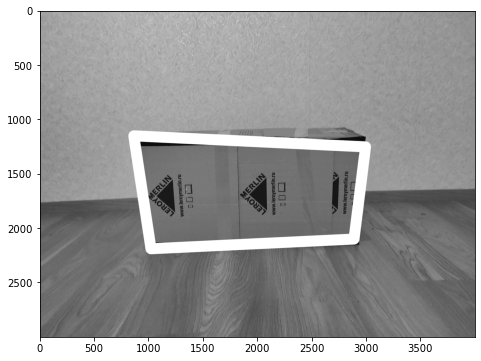

In [13]:
buffer = box.copy()

obj_corners = np.empty((len(box_coord),1,2), dtype=np.float32)
for i in range(len(box_coord)):
    obj_corners[i,0,0] = box_coord[i][0]
    obj_corners[i,0,1] = box_coord[i][1]
#scene_corners = cv.perspectiveTransform(obj_corners, H)

cv.line(buffer, (int(obj_corners[0,0,0]), int(obj_corners[0,0,1])),\
    (int(obj_corners[1,0,0]), int(obj_corners[1,0,1])), (255,255,255), 100)
cv.line(buffer, (int(obj_corners[1,0,0]), int(obj_corners[1,0,1])),\
    (int(obj_corners[2,0,0]), int(obj_corners[2,0,1])), (255,255,255), 100)
cv.line(buffer, (int(obj_corners[2,0,0]), int(obj_corners[2,0,1])),\
    (int(obj_corners[3,0,0]), int(obj_corners[3,0,1])), (255,255,255), 100)
cv.line(buffer, (int(obj_corners[3,0,0]), int(obj_corners[3,0,1])),\
    (int(obj_corners[0,0,0]), int(obj_corners[0,0,1])), (255,255,255), 100)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.imshow(buffer, cmap='gray')

Найдём отображение границ коробки на исходное изображение.

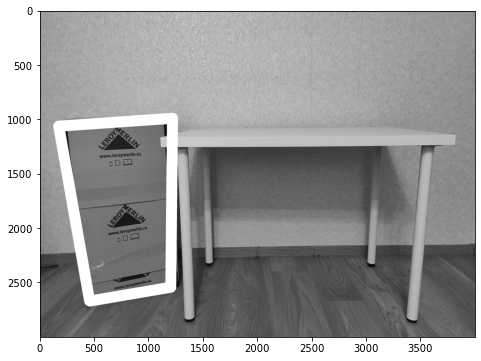

In [14]:
buffer = scene_grayscale.copy()

obj_corners = np.empty((len(box_coord),1,2), dtype=np.float32)
for i in range(len(box_coord)):
    obj_corners[i,0,0] = box_coord[i][0]
    obj_corners[i,0,1] = box_coord[i][1]
scene_corners = cv.perspectiveTransform(obj_corners, H)

cv.line(buffer, (int(scene_corners[0,0,0]), int(scene_corners[0,0,1])),\
        (int(scene_corners[1,0,0]), int(scene_corners[1,0,1])), (255,255,255), 100)
cv.line(buffer, (int(scene_corners[1,0,0]), int(scene_corners[1,0,1])),\
    (int(scene_corners[2,0,0]), int(scene_corners[2,0,1])), (255,255,255), 100)
cv.line(buffer, (int(scene_corners[2,0,0]), int(scene_corners[2,0,1])),\
    (int(scene_corners[3,0,0]), int(scene_corners[3,0,1])), (255,255,255), 100)
cv.line(buffer, (int(scene_corners[3,0,0]), int(scene_corners[3,0,1])),\
    (int(scene_corners[0,0,0]), int(scene_corners[0,0,1])), (255,255,255), 100)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.imshow(buffer, cmap='gray')

Теперь будем находить границы проёмов стола. Будем опираться на белый цвет стола.

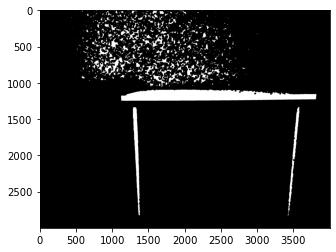

In [15]:
def getTableMask(scene):
    table = scene.copy()
    thresh = 175
    table[table[:,:,:] < thresh] = 0
    table[table[:,:,:] > thresh] = 255
    table = cv.cvtColor(table, cv.COLOR_BGR2GRAY)
    table = binary_erosion(table, selem=np.ones((20, 20)))
    return table

plt.imshow(getTableMask(scene), cmap='gray')

Так как у проёма нет видимой нижней границы, поэтому будем искать её при помощи ножек стола.
Найдём нижнюю часть ножек.

<ipython-input-16-da969dddb995>:10: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  rr, cc = circle(x, y, 100)


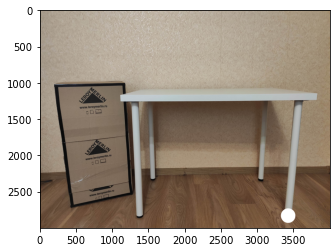

In [16]:
def findTableBottom(scene, show_img):
    table = getTableMask(scene)

    idx = np.nonzero(table)
    x = idx[0][-1]
    y = idx[1][-1]

    if show_img == True:
        table = scene.copy()
        rr, cc = circle(x, y, 100)
        table[rr, cc] = 255
        plt.imshow(cv.cvtColor(table, cv.COLOR_BGR2RGB))
    
    return y, x

bot_table_x, bot_table_y = findTableBottom(scene, True)

Содиним нижние части ножек и добавим точки, при помощи метода аналогичного поиску границ коробки.

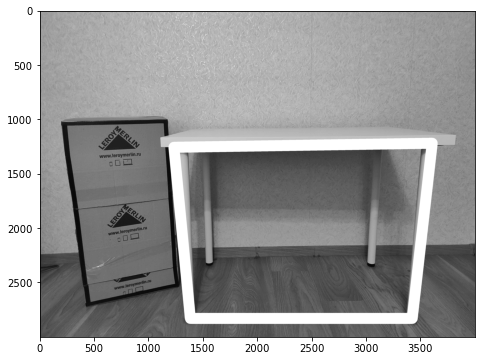

In [17]:
table_mask = getTableMask(scene)

vert_lines = getBorders(table_mask, 'vert')
horz_lines = getBorders(table_mask, 'horz')

box_coord = []

box_coord.append(intersection(vert_lines[0], horz_lines[0]))
box_coord.append(intersection(vert_lines[1], horz_lines[0]))

if (abs(bot_table_x - box_coord[1][0]) < abs(bot_table_x - box_coord[0][0])):
    box_coord.append((bot_table_x, bot_table_y))
    angle = vert_lines[0][1]
    dist = vert_lines[0][0]
    x = (dist - bot_table_y * np.sin(angle)) / np.cos(angle)
    box_coord.append((x, bot_table_y))
else:
    angle = vert_lines[1][1]
    dist = vert_lines[1][0]
    x = (dist - bot_table_y * np.sin(angle)) / np.cos(angle)
    box_coord.append((x, bot_table_y))
    box_coord.append((bot_table_x, bot_table_y)) 
    
buffer = scene_grayscale.copy()

table_corners = np.empty((len(box_coord),1,2), dtype=np.float32)
for i in range(len(box_coord)):
    table_corners[i,0,0] = box_coord[i][0]
    table_corners[i,0,1] = box_coord[i][1]

cv.line(buffer, (int(table_corners[0,0,0]), int(table_corners[0,0,1])),\
    (int(table_corners[1,0,0]), int(table_corners[1,0,1])), (255,255,255), 100)
cv.line(buffer, (int(table_corners[1,0,0]), int(table_corners[1,0,1])),\
    (int(table_corners[2,0,0]), int(table_corners[2,0,1])), (255,255,255), 100)
cv.line(buffer, (int(table_corners[2,0,0]), int(table_corners[2,0,1])),\
    (int(table_corners[3,0,0]), int(table_corners[3,0,1])), (255,255,255), 100)
cv.line(buffer, (int(table_corners[3,0,0]), int(table_corners[3,0,1])),\
    (int(table_corners[0,0,0]), int(table_corners[0,0,1])), (255,255,255), 100)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.imshow(buffer, cmap='gray')

Оценим проходит ли объект. Сделаем это следующим образом: оценим соотношение размерностей (ширина и высота) границ коробки и стола.

In [18]:
min_table_width = scene.shape[1]
min_table_height = scene.shape[0]

for i in range(2):
    for j in range(2):
        min_table_width = min(min_table_width, abs(table_corners[3*i, 0, 0] - table_corners[j + 1, 0, 0]))
        min_table_height = min(min_table_height, abs(table_corners[i, 0, 1] - table_corners[j + 2, 0, 1]))

max_box_width = 0
max_box_height = 0

for i in range(2):
    for j in range(2):
        max_box_width = max(max_box_width, abs(scene_corners[3*i, 0, 0] - scene_corners[j + 1, 0, 0]))
        max_box_height = max(max_box_height, abs(scene_corners[i, 0, 1] - scene_corners[j + 2, 0, 1]))
            
isPassed = min_table_width > max_box_width and min_table_height > max_box_height

if isPassed:
    print("Объект проходит под стол")
else:
    print("Объект НЕ проходит под стол")

Объект НЕ проходит под стол
